In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Load datasets
orders = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_orders_dataset.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_customers_dataset.csv')
reviews = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_reviews_dataset.csv')
items = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_items_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_sellers_dataset.csv')
products = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_products_dataset.csv')

In [3]:
# 2. DATA MERGING
# ==============
merged = (
    orders.merge(customers, on='customer_id')
    .merge(reviews, on='order_id')
    .merge(items, on='order_id')
    .merge(sellers, on='seller_id')
    .merge(products, on='product_id'))

In [4]:
# 3. DATA PREPARATION
# ===================
# Filter for furniture products
furniture_data = merged[merged['product_category_name'] == 'moveis_decoracao']

In [5]:
# Convert dates and calculate delivery speed
furniture_data['order_purchase_timestamp'] = pd.to_datetime(furniture_data['order_purchase_timestamp'])
furniture_data['order_delivered_customer_date'] = pd.to_datetime(furniture_data['order_delivered_customer_date'])
furniture_data['delivery_speed'] = (furniture_data['order_delivered_customer_date'] - furniture_data['order_purchase_timestamp']).dt.days

C:\Users\q\AppData\Local\Temp\ipykernel_19232\3567784973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture_data['order_purchase_timestamp'] = pd.to_datetime(furniture_data['order_purchase_timestamp'])
C:\Users\q\AppData\Local\Temp\ipykernel_19232\3567784973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture_data['order_delivered_customer_date'] = pd.to_datetime(furniture_data['order_delivered_customer_date'])
C:\Users\q\AppData\Local\Temp\ipykernel_19232\3567784973.py:4: SettingWithCo

In [6]:
# Remove outliers
furniture_data = furniture_data[
    (furniture_data['delivery_speed'] > 0) & 
    (furniture_data['delivery_speed'] < 60)  # 你的标准
     & (~furniture_data['price'].isna())   # 我可能加了这类条件
]

In [80]:
# 4. EDA
# ==============
print("\nRunning exploratory analysis...")
plt.figure(figsize=(12,5))


Running exploratory analysis...


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Delivery Time Distribution (Furniture Orders)')

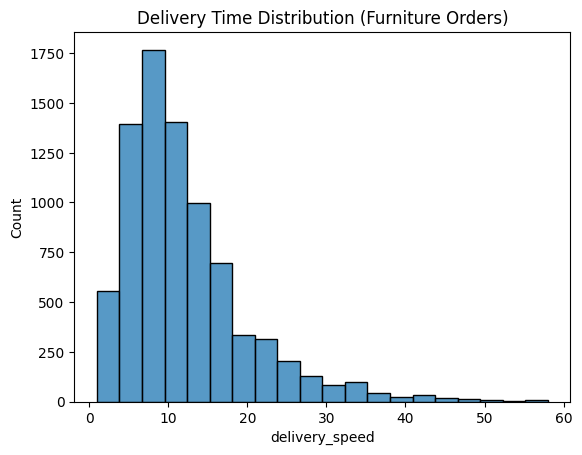

In [96]:
# Delivery speed distribution
sns.histplot(furniture_data['delivery_speed'], bins=20)
plt.title('Delivery Time Distribution (Furniture Orders)')

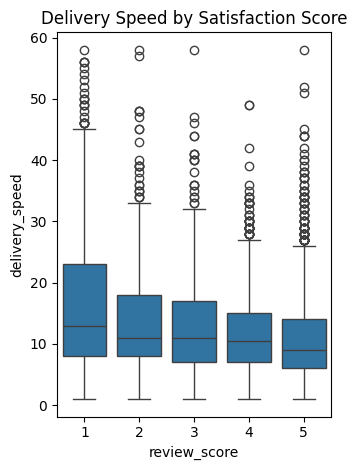

In [82]:
# Delivery speed vs Satisfaction
plt.subplot(1,2,2)
sns.boxplot(x='review_score', y='delivery_speed', data=furniture_data)
plt.title("Delivery Speed by Satisfaction Score")
plt.tight_layout()
plt.show()

In [94]:
furniture_data.groupby(pd.cut(furniture_data['delivery_speed'], 
                       bins=[0,7,14,60]))['review_score'].mean()

delivery_speed
(0, 7]      4.171748
(7, 14]     4.042040
(14, 60]    3.595735
Name: review_score, dtype: float64

In [83]:
# Calculate correlation
delivery_corr = furniture_data['delivery_speed'].corr(furniture_data['review_score'])
print(f"\nCorrelation between delivery speed and satisfaction: {delivery_corr:.3f}")


Correlation between delivery speed and satisfaction: -0.257


In [84]:
# 5. EXPERIMENT DESIGN
# ==============
# Define fast sellers (top 20% fastest)
fast_threshold = furniture_data['delivery_speed'].quantile(0.2)
furniture_data['fast_seller'] = furniture_data['delivery_speed'] <= fast_threshold

In [85]:
# Assign groups
np.random.seed(42)
furniture_data['group'] = np.random.choice(
    ['test', 'control'], 
    size=len(furniture_data),
    p=[0.5, 0.5])

In [86]:
print(f"有效订单：{len(furniture_data)}条")
print(f"测试组样本：{len(furniture_data[furniture_data['group']=='test'])}条")
print(f"对照组样本：{len(furniture_data[furniture_data['group']=='control'])}条")

有效订单：8124条
测试组样本：4109条
对照组样本：4015条


In [87]:
# Test group: Only include top 20 displayed items
test_group = furniture_data[furniture_data['group'] == 'test'].copy()
test_group['display_rank'] = test_group.groupby('customer_id')['fast_seller'].rank(ascending=False)
test_group = test_group[test_group['display_rank'] <= 20]

In [88]:
# Control group: All items
control_group = furniture_data[furniture_data['group'] == 'control']

In [89]:
# 4. BALANCE CHECK
# ==============
print("\n=== BALANCE CHECK ===")
print(f"Test group size: {len(test_group)}")
print(f"Control group size: {len(control_group)}")

balance_vars = ['price', 'product_weight_g', 'delivery_speed']
balance_results = []

for var in balance_vars:
    t_stat, p_val = stats.ttest_ind(
        test_group[var].dropna(),
        control_group[var].dropna(),
        equal_var=False
    )
    balance_results.append({
        'variable': var,
        'test_mean': test_group[var].mean(),
        'control_mean': control_group[var].mean(),
        'p_value': p_val
    })

print(pd.DataFrame(balance_results))


=== BALANCE CHECK ===
Test group size: 4109
Control group size: 4015
           variable    test_mean  control_mean   p_value
0             price    86.092502     88.170232  0.283962
1  product_weight_g  2598.166951   2667.598007  0.413369
2    delivery_speed    12.036262     12.008717  0.875787


In [90]:
# 5. RESULT ANALYSIS
# ==============
print("\n=== PRIMARY RESULTS ===")
# Compare satisfaction
test_scores = test_group['review_score']
control_scores = control_group['review_score']

print(f"Test Group Satisfaction: {test_scores.mean():.2f}")
print(f"Control Group Satisfaction: {control_scores.mean():.2f}")
t_stat, p_val = stats.ttest_ind(test_scores, control_scores)
print(f"Difference: {test_scores.mean() - control_scores.mean():.2f}")
print(f"p-value: {p_val:.4f}")


=== PRIMARY RESULTS ===
Test Group Satisfaction: 3.96
Control Group Satisfaction: 3.96
Difference: -0.00
p-value: 0.9754


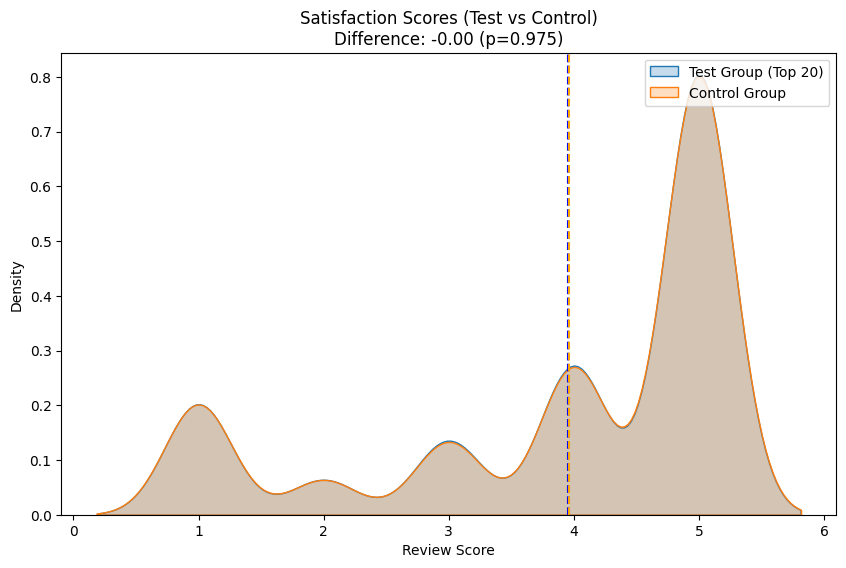

In [91]:
# Visualization
plt.figure(figsize=(10,6))
sns.kdeplot(test_scores, label=f'Test Group (Top {TOP_DISPLAY})', fill=True)
sns.kdeplot(control_scores, label='Control Group', fill=True)
plt.axvline(x=test_scores.mean(), color='blue', linestyle='--')
plt.axvline(x=control_scores.mean(), color='orange', linestyle='--')
plt.title(f"Satisfaction Scores (Test vs Control)\nDifference: {test_scores.mean()-control_scores.mean():.2f} (p={p_val:.3f})")
plt.xlabel('Review Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [92]:
# 6. DEEP VALIDATION
# ==============
print("\n=== FAST SELLER PERFORMANCE ===")
fast_seller_scores = test_group[test_group['fast_seller']]['review_score']
other_seller_scores = test_group[~test_group['fast_seller']]['review_score']

print(f"Fast sellers count: {len(fast_seller_scores)}")
print(f"Fast sellers mean score: {fast_seller_scores.mean():.2f}")
print(f"Other sellers mean score: {other_seller_scores.mean():.2f}")
print(f"Difference: {fast_seller_scores.mean() - other_seller_scores.mean():.2f}")
print(f"p-value: {stats.ttest_ind(fast_seller_scores, other_seller_scores)[1]:.4f}")


=== FAST SELLER PERFORMANCE ===
Fast sellers count: 958
Fast sellers mean score: 4.20
Other sellers mean score: 3.88
Difference: 0.32
p-value: 0.0000
